In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

y20= np.loadtxt('radar-measurements.txt')
y20.shape
# y20

(50, 2)

In [50]:
# plt.scatter(y20[:,0], y20[:,1])
# plt.show()

You can do anything in numpy that you would have done in Matlab.  One small caution:  make sure your arrays are of type Matrix instead of numpy arrays so that the multiplication operator * acts like a matrix multiply rather than an element-by-element multiply.  The default * operator for numpy arrays is equivalent to the Matlab .* element by element multiply.  

In [3]:
def kalman_update(x, P, y, R, G, Q, A, C):
    '''
    Parameters:
    x: initial state
    P: initial uncertainty convariance matrix
    y: observed position measurement (same shape as C*x)
    R: measurement noise convariance matrix(same shape as C)
    Q: motion noise convariance matrix 
    A: next state function: x_prime = A*x+G*w
    C: measurement function: y = C*x+v

    Return: the updated new values for (x, P)
    '''
    # UPDATE x, P; x(t|t), P(t|t) based on measurement y   and x(t|t-1), P(t|t-1)
    S = C * P * C.T + R  # residual convariance
    K = P * C.T * S.I    # Kalman gain
    x = x + K*(y.T - C * x)#np.matrix(y)
    P = P - K*C*P
#     I = np.matrix(np.eye(A.shape[0])) # identity matrix
#     P = (I - K*C)*P

    return x, P

def kalman_predict(x, P, y, R, G, Q, A, C):
    '''
    Return: the  predicted new values for (x, P)
    '''
    # PREDICT x(t+1|t), P(t+1|t) based after updated value x(t|t), P(t|t)
    x = A*x 
    P = A*P*A.T + G*Q*G.T

    return x, P

In [20]:
x = np.matrix(np.zeros((6, 1)))
P = np.matrix(np.diag([ 10**8, 10**8,  10**4,  10**2,  10**2,  10**2]))#np.matrix(np.eye(6)) # initial uncertainty
Q= np.matrix(np.zeros((6,6)))
Q[2,2]=1225
Q[5,5]=0.0001
R = np.matrix(np.diag([ 10**4,  0.0025]))#0.16*np.matrix(np.eye(2))
G = np.matrix(np.eye(6)) 

T=5
p=0.5
A = np.matrix(np.zeros((6,6)))
A33=np.matrix([[ 1.,  T,  0.],
            [ 0.,  1.,  1],
            [ 0.,  0.,  p]])
A[:3,:3]=A33
A[3:,3:]=A33

C=np.matrix([[ 1.,  0., 0.,  0.,  0.,  0.],
             [ 0.,  0., 0,   1.,  0.,  0.]])

# 4 (b)

In [34]:
result = []    
resultP = [] 
for y in y20:
    y=np.matrix(y)# row matrix
    x, P = kalman_update(x, P, y, R, G, Q, A, C)
    result.append((x[[0,3]]).tolist())
    resultP.append((np.diag(P)[[0,3]]).tolist())
    x, P = kalman_predict(x, P, y, R, G, Q, A, C)

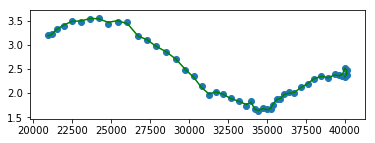

In [162]:
kalman_x, kalman_y = zip(*result)
plt.figure(figsize=(6,2))
plt.plot(kalman_x, kalman_y, 'g-')
plt.scatter(y20[:,0], y20[:,1])
plt.show()

green line is Kalman filter;
blue scatter is  y, noisy observation of r, theta (r, θ) 

# 4 (c)

In the homework folder, there is a file called radar-measurements.txt, wich corresponds to 50 mea-
surements of an object flying through this two-dimensional air space, sampled at 5 second intervals. The
measurements are stored as a 50 x 2 matrix, with the first row corresponding to the noisy measurement
(r, θ) at time 0. Run your Kalman filter with these measurements, and obtain the updated estimate
of (r, θ) after 25 measurements are processed (ˆ
x (24|24)). Record these and the values of the standard
deviation of the error in estimating r and θ, obtained from the respective diagonal entries of the updated
covariance P (t|t).

In [44]:
print('updated estimate of (r, θ) after 25 measurements are' +str(kalman_x[24]) +'and' + str(kalman_y[24] ))

updated estimate of (r, θ) after 25 measurements are[33992.14714557971]and[1.804114042527401]


In [49]:
print('standard deviation of the error in estimating r and θ are ' +str(resultP[24]))

standard deviation of the error in estimating r and θ are [8921.638789263408, 0.002059660597678578]


# 4 (d)

(d) Implement a non-causal smoothing algorithm for this problem, and process all 50 measurements to
generate the smoothed estimate of (r, θ) corresponding to x
ˆ (24|49). Report this value and the standard
deviations for estimating r, θ obtained from the respective diagonal entries of the smoothed covariance
P (24|49).


Forward Kalman Filter

In [56]:
N=y20.shape[0]
n_x=6

In [89]:
x = np.matrix(np.zeros((6, 1)))
P = np.matrix(np.diag([ 10**8, 10**8,  10**4,  10**2,  10**2,  10**2]))#np.matrix(np.eye(6)) # initial uncertainty

result_z = np.matrix(np.zeros((n_x,N)))#[]    
result_invP = np.zeros((N, n_x, n_x))#np.matrix()#[] 
k= 0
for y in y20:
    y=np.matrix(y)# row matrix
    x, P = kalman_update(x, P, y, R, G, Q, A, C)
    result_z[:,k] = P.I*x
    result_invP[k,:,:]= P.I
#     result.append((x[[0,3]]).tolist())
#     resultP.append((np.diag(P)[[0,3]]).tolist())
    x, P = kalman_predict(x, P, y, R, G, Q, A, C)
    k= k + 1

In [78]:
# check whether it's consistent with 4(c)
np.diag(np.matrix(result_invP[24,:,:]).I)

array([  8.92163879e+03,   2.21415473e+03,   1.56992649e+03,
         2.05966060e-03,   2.45832804e-04,   1.29530903e-04])

Backward Kalman Filter with information form

In [80]:
# A invertible for information form, G=I
def kalman_update_information(z, Pinv, y, R, G, Q, A, C):
    '''
    Parameters:
    x: initial state
    P: initial uncertainty convariance matrix
    z: Pinv*x
    Pinv: P inverse
    y: observed position measurement (same shape as C*x)
    R: measurement noise convariance matrix(same shape as C)
    Q: motion noise convariance matrix 
    A: next state function: x_prime = A*x+G*w
    C: measurement function: y = C*x+v

    Return: the updated new values for (x, P)
    '''
    # UPDATE  z(t|t), Pinv(t|t) based on measurement y   and x(t|t-1), P(t|t-1)
    z= z+ C.T * R.I *y 
    Pinv= Pinv + C.T * R.I * C    
    return z, Pinv

def kalman_predict_information(z, Pinv, y, R, G, Q, A, C):
    '''
    Return: the  predicted new values for (x, P)
    '''
    # PREDICT z(t+1|t), Pinv(t+1|t) based after updated value x(t|t), P(t|t)
    Identity = np.matrix(np.eye(A.shape[0])) # identity matrix
    M= A.I.T * Pinv * A.I
    N= M *G *Q *(Identity + G.T* M *G *Q ).I
    z= (Identity + M *G *Q *G.T ).I * A.I.T * z
#     [Identity - N] *A.I.T *z
    Pinv=M-N*G.T*M #(Identity + M *G *Q *G.T ).I * M

    return z, Pinv

In [92]:
y_reverse= np.flip(y20,0)
Ainv=A.I
Gnew=Ainv

z=0
Pinv=np.matrix(np.zeros((n_x, n_x)))
# y1
result_z_back = np.matrix(np.zeros((n_x,N)))#[]    
result_invP_back = np.zeros((N, n_x, n_x))#np.matrix()#[] 

k= 0
for y in y_reverse:
    y=np.matrix(y).T# row matrix
    z, Pinv = kalman_update_information(z, Pinv, y, R, Gnew, Q, Ainv, C)
    z, Pinv = kalman_predict_information(z, Pinv, y, R, Gnew, Q, Ainv, C)
    result_z_back[:,k] = z
    result_invP_back[k,:,:]= Pinv
    k= k + 1

In [145]:
# # result_z_back
# plt.plot(range(len(result_z_back.T)), result_z_back.T, 'g-')
# plt.show()

In [126]:
z_smooth=result_z + np.flip(result_z_back,1)
z_smooth24=z_smooth[:,24]

x_49=np.matrix(np.zeros((N,n_x)))
Pinv_smooth=result_invP_back.copy()
for k in range(N):
    Pinv_smooth[k,:,:]+=result_invP[k,:,:]
    x_49[k,:] = (np.matrix(Pinv_smooth[k,:,:]).I  * z_smooth[:,k]).T
#     print(k)

x24_49=np.matrix(Pinv_smooth[24,:,:]).I * z_smooth24
P24_49=np.matrix(Pinv_smooth[24,:,:]).I 

In [127]:
x_49[24]

matrix([[  3.40630962e+04,  -2.75763483e+01,  -2.84815705e+01,
           1.76585017e+00,   5.11442195e-03,  -3.75723278e-03]])

In [124]:
print('the smoothed estimate of (r, θ) corresponding to x(24|49) is' + str(x24_49[[0,3]]))
print('the standard deviations for estimating r, θ is' + str(np.diag(P24_49)[[0,3]]) +
       ' obtained from the respective diagonal entries of the smoothed covariance P(24|49).')

the smoothed estimate of (r, θ) corresponding to x(24|49) is[[  3.40630962e+04]
 [  1.76585017e+00]]
the standard deviations for estimating r, θ is[  4.94992042e+03   9.66380312e-04] obtained from the respective diagonal entries of the smoothed covariance P(24|49).


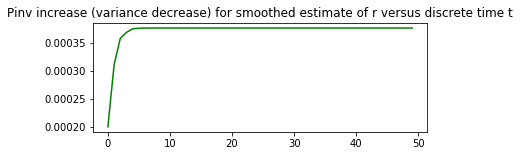

In [163]:
plt.figure(figsize=(6,2))
plt.plot(range(len((Pinv_smooth[:,0,0]))), Pinv_smooth[:,0,0], 'g-')
plt.title('Pinv increase (variance decrease) for smoothed estimate of r versus discrete time t')
plt.show()

# 4 (e)

(e) Show a single plot comparing the filtered estimate of r versus discrete time t and the smoothed estimate of r versus discrete time t. Show another plot for the filtered estimate of θ versus discrete time t and the smoothed estimate of theta.

In [133]:
#CALCULATE filter
x_49_filter=np.matrix(np.zeros((N,n_x)))
for k in range(N):
    x_49_filter[k,:] = (np.matrix(result_invP[k,:,:]).I  * result_z[:,k]).T

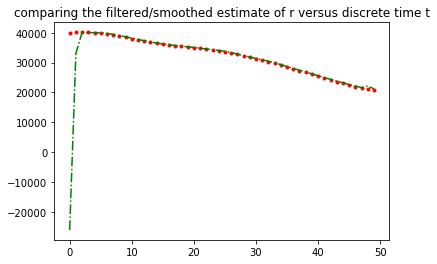

In [139]:
plt.plot(range(len(x_49_filter[:,0])), x_49_filter[:,0], 'r.')
plt.plot(range(len(x_49[:,0])), x_49[:,0], 'g-.')
plt.title('comparing the filtered/smoothed estimate of r versus discrete time t')
plt.show()

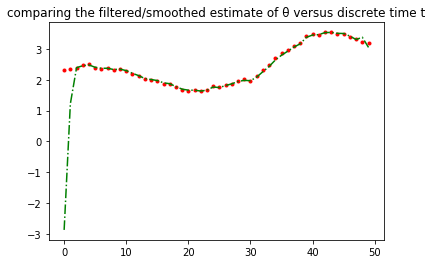

In [140]:
plt.plot(range(len(x_49_filter[:,3])), x_49_filter[:,3], 'r.')
plt.plot(range(len(x_49[:,3])), x_49[:,3], 'g-.')
plt.title('comparing the filtered/smoothed estimate of θ versus discrete time t')
plt.show()

In [165]:
# plt.figure(figsize=(6,2))
# plt.plot(x_49_filter[:,0], x_49_filter[:,3], 'r.')
# plt.show()